In [29]:
import tidy3d as td
import tidy3d.plugins.adjoint as tda
from tidy3d.plugins.adjoint.web import run_local as run

In [30]:
import numpy as np
import matplotlib.pylab as plt

In [31]:
import jax
import jax.numpy as jnp

In [32]:
wavelength = 1.0
freq0 = td.C_0 / wavelength

fwidth = freq0 / 10
num_freqs = 10
freqs = np.linspace(freq0 - fwidth/2, freq0 + fwidth/2, num_freqs)

num_pts = 40
angles = np.linspace(0, np.pi/2, num_pts + 2)[1:-1]

n_wg = 2.0

spc = 1 * wavelength
t = 1 * wavelength
mode_spc = t / 2.0

wmid = 0.6 * wavelength
wmax = 0.9 * wavelength
wmin = 0.3 * wavelength

radius = 3 * wavelength

monitor_name = "mode"

min_steps_per_wvl = 25

In [33]:
Lx = Ly = t + radius + abs(wmax - wmid) + spc
Lz = 0.0

In [34]:
def thickness(param: float) -> float:
    param_01 = (jnp.tanh(param) + 1.0) / 2.0
    return wmax * param_01 + wmin * (1 - param_01)

In [35]:
def make_vertices(params):
    vertices = []
    vertices.append((Lx/2 - t, Ly/2 - t - radius - wmid/2))
    for angle, param in zip(angles, params):
        thickness_i = thickness(param)
        radius_i = radius + thickness_i/2.0
        x = -radius_i * np.sin(angle) + Lx/2 - t
        y = -radius_i * np.cos(angle) + Ly/2 - t
        vertices.append((x, y))
    vertices.append((Lx/2 - t - radius - wmid/2, Ly/2 - t))
    vertices.append((Lx/2 - t - radius + wmid/2, Ly/2 - t))
    for angle, param in zip(angles[::-1], params[::-1]):
        thickness_i = thickness(param)
        radius_i = radius - thickness_i/2.0
        x = -radius_i * np.sin(angle) + Lx/2 - t
        y = -radius_i * np.cos(angle) + Ly/2 - t
        vertices.append((x, y))    
    vertices.append((Lx/2 - t, Ly/2 - t - radius + wmid/2))
    return vertices
        


In [36]:
params = 0 * np.random.random(num_pts) - 0.5 * 0
vertices = make_vertices(params)

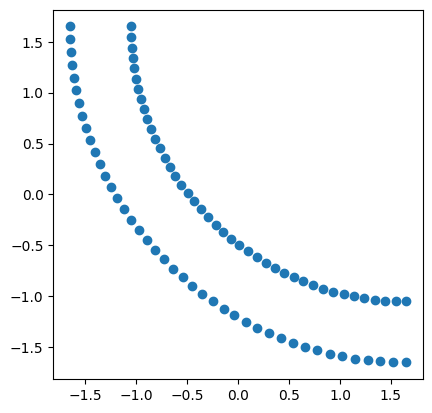

In [37]:
plt.scatter(*np.array(vertices).T)
ax = plt.gca()
ax.set_aspect("equal")

In [38]:
def make_polyslab(params) -> tda.JaxPolySlab:
    vertices = make_vertices(params)
    return tda.JaxPolySlab(
        vertices=vertices,
        slab_bounds=(-1,1),
        axis=2,
    )    

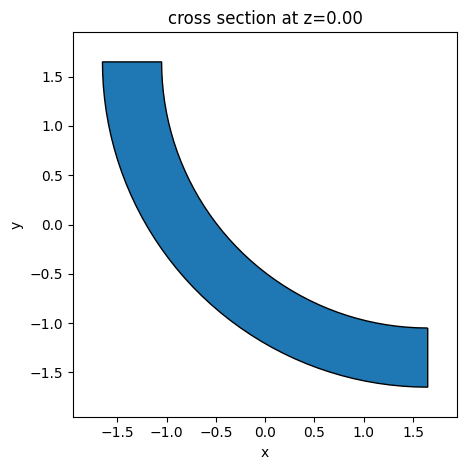

In [39]:
polyslab = make_polyslab(params)
ax = polyslab.plot(z=0)

In [40]:
def make_input_structures(params) -> list[tda.JaxPolySlab]:
    polyslab = make_polyslab(params)
    medium = tda.JaxMedium(permittivity=n_wg**2)
    return [tda.JaxStructure(geometry=polyslab, medium=medium)]

box_in = td.Box.from_bounds(
    rmin=(Lx/2 - t, Ly/2 - t - radius - wmid/2, -1),
    rmax=(Lx/2 + 1, Ly/2 - t - radius + wmid/2, +1),
)
box_out = td.Box.from_bounds(
    rmin=(Lx/2 - t - radius - wmid/2, Ly/2 - t, -1),
    rmax=(Lx/2 - t - radius + wmid/2, Ly/2 + 1, +1),
)
wg_in = td.Structure(geometry=box_in, medium=td.Medium(permittivity=n_wg**2))
wg_out = td.Structure(geometry=box_out, medium=td.Medium(permittivity=n_wg**2))


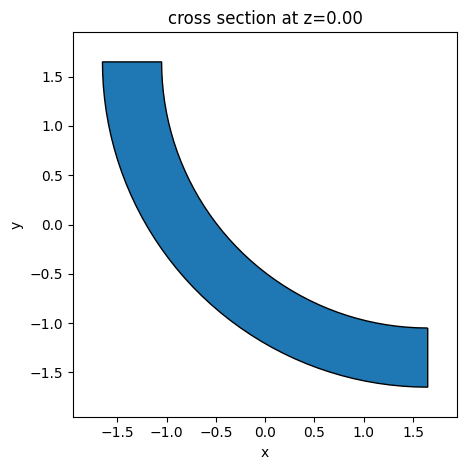

In [41]:
(ring,) = input_structures = make_input_structures(params)
ax = ring.plot(z=0)

In [42]:
mode_size = wmax * 4

mode_src = td.ModeSource(
    size=(0, mode_size, 1),
    center=(Lx/2 - t/2, Ly/2 - t - radius, 0),
    direction="-",
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth,
    )
)

In [43]:
mode_mnt = td.ModeMonitor(
    size=(mode_size, 0, 1),
    center=(Lx/2 - t - radius, +Ly/2 - t/2, 0),
    name=monitor_name,
    freqs=[freq0],
    mode_spec=td.ModeSpec(),
)

mode_mnt_bb = td.ModeMonitor(
    size=(mode_size, 0, 1),
    center=(Lx/2 - t - radius, +Ly/2 - t/2, 0),
    name="mode_bb",
    freqs=freqs.tolist(),
    mode_spec=td.ModeSpec(),
)

fld_mnt = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field",
)

In [44]:

def make_sim(params, use_fld_mnt: bool = True) -> tda.JaxSimulation:
    monitors = [mode_mnt_bb]
    if use_fld_mnt:
        monitors += [fld_mnt]
    input_structures = make_input_structures(params)
    return tda.JaxSimulation(
        size=(Lx, Ly, Lz),
        input_structures=input_structures,
        structures=[wg_in, wg_out],
        sources=[mode_src],
        output_monitors=[mode_mnt],
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl),
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
        monitors=monitors,
        run_time = 10/fwidth,
)

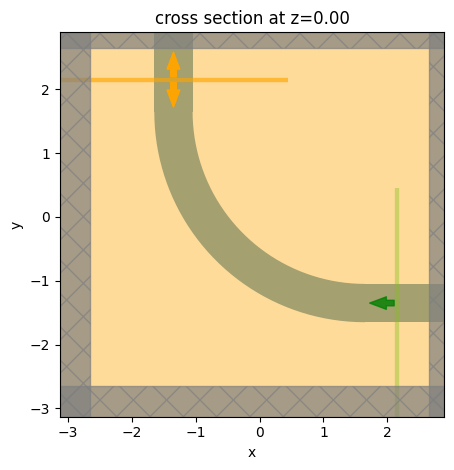

In [45]:
sim = make_sim(params)
ax = sim.plot(z=0)

In [46]:
from tidy3d.plugins.adjoint.utils.penalty import RadiusPenalty

penalty = RadiusPenalty(min_radius=0.150, alpha=1.0, kappa=10.0)


In [47]:
def objective(params, use_fld_mnt:bool = True):
    sim = make_sim(params, use_fld_mnt=use_fld_mnt)
    sim_data = run(sim, task_name='bend', verbose=False)
    amps = sim_data[monitor_name].amps.sel(direction="+").values
    transmission = jnp.abs(jnp.array(amps))**2
    vertices = make_vertices(params)
    J = jnp.sum(transmission) - penalty.evaluate(vertices)
    aux = sim_data
    return J, aux

In [20]:
val_grad = jax.value_and_grad(objective, has_aux=True)

In [21]:
(val, sim_data), grad = val_grad(params)

[10:49:48] WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=760681;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=629413;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=551879;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=823740;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=167068;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=138001;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=760742;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=927470;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=346706;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=594052;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=265699;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=82276;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=587145;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=546810;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=23992;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=734285;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

[10:50:35] WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=27719;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=907976;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=23879;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=578171;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=735005;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=324415;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=410103;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=155657;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=985784;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=149727;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=771703;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=704179;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=927025;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=368320;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=222433;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=839840;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=466912;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=912474;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=774686;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=537721;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

[10:50:36] WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=644809;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=168816;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=32946;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=62442;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=526873;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=999626;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=439657;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=124331;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=264524;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=232829;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=949128;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=376995;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=254427;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=227250;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=859084;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=376162;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

[10:51:06] WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=79;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=311328;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=709159;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=514305;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=708956;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=853262;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=546622;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=635975;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

In [22]:
print(val)
print(grad)

0.9127503
[ 0.0107107  -0.00672015 -0.02132776 -0.03672322 -0.0516248  -0.06319317
 -0.07023721 -0.07212622 -0.07016801 -0.06327568 -0.05514405 -0.04548211
 -0.03395659 -0.02293381 -0.01048456  0.00297211  0.01547584  0.02677242
  0.03642297  0.04019468  0.0401933   0.03641881  0.02676578  0.01546803
  0.00296503 -0.01048753 -0.02292977 -0.03394295 -0.04545847 -0.05511247
 -0.06323946 -0.07013264 -0.07209516 -0.07021385 -0.06317846 -0.0516182
 -0.03672371 -0.0213322  -0.00672854  0.01539129]


In [23]:
import optax

# turn off warnings to reduce verbosity
td.config.logging_level='ERROR'

# hyperparameters
num_steps = 1
learning_rate = 0.2

# initialize adam optimizer with starting parameters
params = np.array(params).copy()
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
objective_history = []
param_history = [params]
data_history = []

for i in range(num_steps):

    # compute gradient and current objective funciton value
    (value, sim_data), gradient = val_grad(params)
    
    # convert nan to 0 (infinite radius of curvature) and multiply all by -1 to maximize obj_fn.
    gradient = -1 * np.nan_to_num(np.array(gradient.copy()))

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient
    updates, opt_state = optimizer.update(gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # save history
    objective_history.append(value)
    param_history.append(params)
    data_history.append(sim_data)


step = 1
	J = 9.1275e-01
	grad_norm = 2.7763e-01
step = 2
	J = 9.5910e-01
	grad_norm = 2.1497e-01
step = 3
	J = 8.8846e-01
	grad_norm = 4.0696e-01


In [24]:
sim_start = make_sim(param_history[0])
data_start = data_history[0]

sim_final = make_sim(param_history[-1])
data_final = data_history[-1]


<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

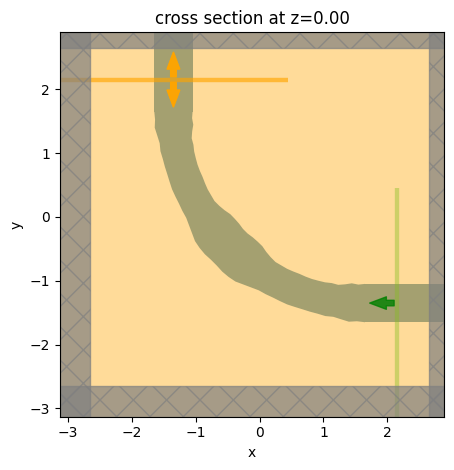

In [25]:
sim_final.plot(z=0)

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

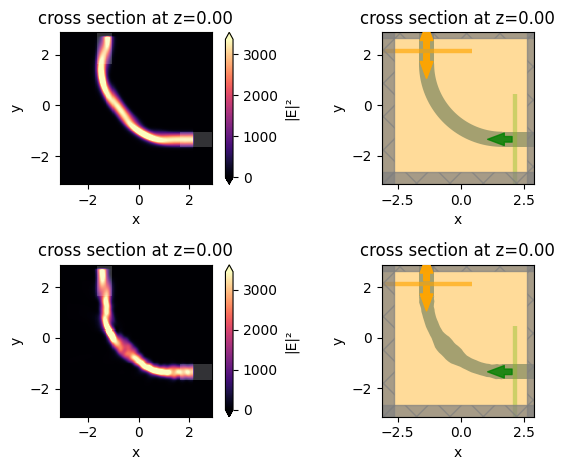

In [26]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True)

data_start.plot_field('field', 'E', 'abs^2', ax=ax1)
sim_start.plot(z=0, ax=ax2)

data_final.plot_field('field', 'E', 'abs^2', ax=ax3)
sim_final.plot(z=0, ax=ax4)


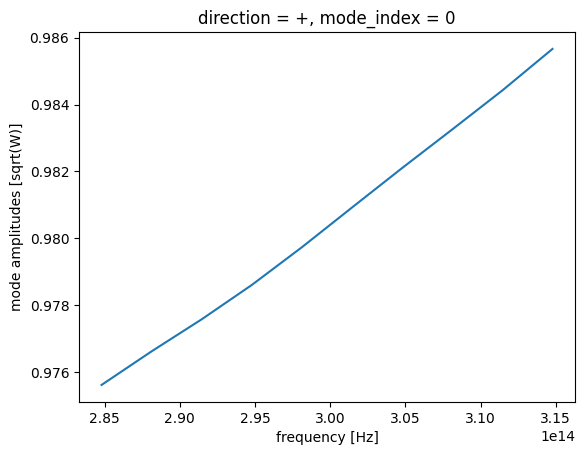

In [27]:
amp_bb = sim_data['mode_bb'].amps.sel(direction="+")
abs(amp_bb).plot(x="f")

In [28]:
amp_bb

<xarray.ModeAmpsDataArray (f: 10, mode_index: 1)>
array([[-0.07558515+0.97268644j],
       [-0.77396655+0.59562613j],
       [-0.96152201-0.17647087j],
       [-0.5129697 -0.83338893j],
       [ 0.27638135-0.93994579j],
       [ 0.88463265-0.42383578j],
       [ 0.9078065 +0.37471993j],
       [ 0.32869962+0.92668782j],
       [-0.47004133+0.86495625j],
       [-0.95875445+0.22873942j]])
Coordinates:
    direction   <U1 '+'
  * f           (f) float64 2.848e+14 2.881e+14 ... 3.115e+14 3.148e+14
  * mode_index  (mode_index) int64 0
Attributes:
    units:      sqrt(W)
    long_name:  mode amplitudes